In [1]:
import datetime
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# All images to be shown inside cells. 
%matplotlib inline
# To help debugging eliminate ellipses whenever reasonable.
np.set_printoptions(precision=3, edgeitems=5, linewidth=100)

In [2]:
class Lcd(object):
  """An LCD like display.
  """
  
  def __init__(self, size=8):
    """Creates a blank size x size LCD like display.
    """
    self._size = size
    self._half = size / 2  # half size of the display
    self._last = size - 1  # index of the last row or col
    self.clear()
    
  def clear(self):
    """Clears this display"""
    self._display = np.zeros((self._size, self._size), dtype=np.int32)
    
  def display(self, digit):
    """Displays the given digit on the display.
    
    Args:
      digit: number
        the number to be shown on the display
    Returns:
      LCD this LCD display
    """
    self.clear()
    try:
      getattr(self, "_%s" % str(digit))()
      return self
    except AttributeError as e:
      raise NotImplementedError("Unable to render %s" % str(digit))
    
  def copyTo(self, mat, x, y):
    mat.fill(0)
    mat[x : x + self._size, y : y + self._size] = self._display
    return mat

  def _hx3(self):
    self._display[0, :] = 1
    self._display[self._half, :] = 1
    self._display[self._last, :] = 1
    
  def _0(self):
    self._display[0, :] = 1
    self._display[self._last, :] = 1
    self._display[:, 0] = 1
    self._display[:, self._last] = 1
    
  def _1(self):
    self._display[:, self._last] = 1
    
  def _2(self):
    self._hx3()
    self._display[0 : self._half, self._last] = 1
    self._display[self._half : self._size, 0] = 1
    
  def _3(self):
    self._hx3()
    self._display[:, self._last] = 1
    
  def _4(self):
    self._display[0 : self._half, 0] = 1
    self._display[self._half, :] = 1
    self._display[:, self._last] = 1

  def _5(self):
    self._hx3()
    self._display[0 : self._half, 0] = 1
    self._display[self._half : self._size, self._last] = 1    
    
  def _6(self):
    self._display[:, 0] = 1
    self._display[self._half, :] = 1
    self._display[self._last, :] = 1
    self._display[self._half : self._size, self._last] = 1
    
  def _7(self):
    self._display[0, :] = 1
    self._display[:, self._last] = 1
    
  def _8(self):
    self._0()
    self._display[self._half, :] = 1
    
  def _9(self):
    self._7()
    self._display[self._half, :] = 1
    self._display[0 : self._half, 0] = 1
    
  def __str__(self):
    return str(self._display)

In [3]:
def GenerateImages(n, s, w, d):
  """Generates n images of size s inside w x w matrix.
  
  Args:
    n: number
      The total number of images to generate
    s: number
      The size of the LCD.
    w: number
      The width and height of the matrix holding LCDs
    d: number
      The number of digits.
  Returns:
    ([n, w, w], [n, d]) a pair of matrices with shapes and
    a vector indicating the kind of the shape.
  """
  if n <= 0:
    return ([], [])
  raster = np.zeros((n, w, w), dtype=np.float32)
  kind = np.zeros((n, d))
  lcd = Lcd(s)
  for i in range(n):
    digit = i % d
    sx = np.random.randint(0, w - s + 1)
    sy = np.random.randint(0, w - s + 1)
    lcd.display(digit).copyTo(raster[i], sx, sy)
    kind[i][digit] = 1
  return (raster, kind)

In [4]:
def ShowAsImages(v, pred_kind, kind_name, w):
  """Shows a binary, flat raster as an image.
  
  Args:
    v: np.array
      an array of bits.
    pred_kind: np.array
      an array of ints indicating the predicted image kind.
    kind_name: list[string]
      A list that has a string corresponding to each kind index.
    w: number
      the width and height of the image
  """
  n = len(v)
  s = np.int(np.sqrt(n))
  t = np.int(np.ceil(np.float(n) / s))
  fig, axes = plt.subplots(s, t)
  fig.set_size_inches(2 * s, 2 * s)
  fig.subplots_adjust(hspace=.6, wspace=.3)
  for i, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    if i >= n:
      ax.axison=False
      continue
    imgplot = ax.imshow(1 - v[i], cmap=plt.cm.binary)
    ax.set_xlabel(kind_name[np.argmax(pred_kind[i])])
  plt.show()

In [5]:
# When learning we break data into batches. 
class BatchMaker(object):
  def __init__(self, img_data, kind, batch_size):
    p = np.random.permutation(len(img_data))
    self.img_data_ = img_data[p]
    self.kind_ = kind[p]
    self.batch_size_ = batch_size
    self.row_count_ = len(img_data)
    self.index_ = 0
    
  def next(self):
    img_slice = self.img_data_[self.index_ : self.index_ + self.batch_size_]
    kind_slice = self.kind_[self.index_ : self.index_ + self.batch_size_]
    self.index_ += self.batch_size_
    if self.index_ >= self.row_count_:
      self.index_ = 0
    return (img_slice, kind_slice)

In [6]:
# The width and the height of each image.
img_size = 5

# The size of each shape.
shape_size = 5

# The total number of training examples.
example_count = 100

# The number of digits (one more than the maximum digit).
kind_count = 10

# The names or labels for each kind:
kind_names = [str(x) for x in range(kind_count)]

In [7]:
img_data, true_kind = GenerateImages(example_count, shape_size, img_size, kind_count)

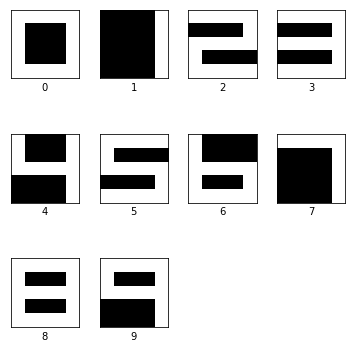

In [8]:
# Show the initial data.
ShowAsImages(img_data[0 : 10, :], true_kind[0 : 10], kind_names, img_size)

In [9]:
# Learning parameters:

# The learning rate. Tells the optimizer how fast to follow the curve
# of the plane.
learning_rate = 0.03

# The number of images we look at a single step.
batch_size = 50

# The total number of steps we are going to run the learning step
step_count = 100

In [10]:
# The placeholder for image bits. The first dimension is None to allow for any number
# of images. Each linear image is converted back to img_size x img_size  matrix.
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size], name='X')
# Reshape the 2D images to a flat vector.
x_flat = tf.reshape(x, [-1, img_size * img_size], name="X_flat")

# The placeholder for true classes. This is what is going to drive neural network
# towards the correct solution.
y_true = tf.placeholder(tf.float32, shape=[None, kind_count], name='y_true')

# Simple model. Multiply each flattened image by (img_size * img_size) x kind_count
# matrix. This produces a vector of size kind_count. Add bias to this vector and then
# use softmax cross entropy to assign a unique class to each result.
W = tf.Variable(tf.zeros([img_size * img_size, kind_count]), name="W")
b = tf.Variable(tf.zeros([kind_count]), name="b")

# Here y is the result of multiplying image data by weight matrix plus bias vector.
y_pred = tf.matmul(x_flat, W) + b
# The loss function tries to reduce mean between true labels and computed labels.
loss_op = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

# The training step uses simple gradient descent that tries to minimize loss_fn.
# It takes
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss_op)

# Compute how many answers we got right.
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
# Compute accuracy as the number of correct predictions / total number of predictions.
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
batch_maker = BatchMaker(img_data, true_kind, batch_size)
step_nbr = 0

Accuracy 0.2


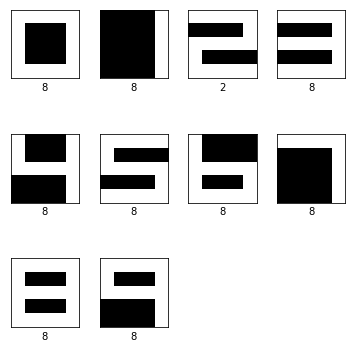

In [12]:
# Run the learning algorithm for 5 steps. Compute
# accuracy and print some predictions.
while step_nbr < 5:
  img_batch, label_batch = batch_maker.next()
  train_op.run(feed_dict={x: img_batch, y_true: label_batch})
  step_nbr += 1
  
# Compute current predictions.
pred_kind = y_pred.eval(feed_dict={x: img_data})
  
print "Accuracy", accuracy_op.eval(feed_dict={x: img_data, y_true: true_kind})
ShowAsImages(img_data[0 : 10, :],  pred_kind[0 : 10], kind_names, img_size)

In [13]:
# Run the algorithm for the remaining step_count - 5 steps we already did.
while step_nbr < step_count - 5:
  img_batch, label_batch = batch_maker.next()
  fd = {x: img_batch, y_true: label_batch}
  train_op.run(feed_dict=fd)
  step_nbr += 1
# Compute final predictions.
pred_kind = y_pred.eval(feed_dict={x: img_data})
# Compute final weight and biases.
W_final = sess.run(W)
b_final = sess.run(b)

Accuracy 1.0


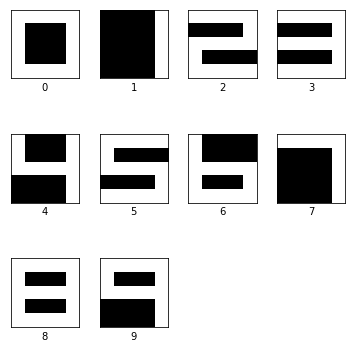

In [14]:
print "Accuracy", accuracy_op.eval(feed_dict={x: img_data, y_true: true_kind})
ShowAsImages(img_data[0 : 10, :], pred_kind[0 : 10], kind_names, img_size)

In [15]:
# Compute confusion matrix. If there are any errors, this shows us
# What confuses the model. For example, initially 3 and 8 might be
# considered very close.
cm = sess.run(tf.contrib.metrics.confusion_matrix(tf.argmax(pred_kind, 1), 
                                                  tf.argmax(true_kind, 1)))

[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


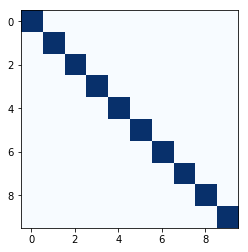

In [16]:
# Show the confusion matrix. We both show numeric values and
# heatmap representation.
print cm
cm_img = np.divide(cm.astype(np.float32), cm.sum(axis=1).reshape((kind_count, 1)), where=cm != 0)
_ = plt.imshow(cm_img, interpolation='nearest', cmap=plt.cm.Blues)

In [17]:
def Explain(W, b, s, w):
  """Produces a series of images that explain how W favors given digit.
  
  Args:
    W: np.array((s * s, 10))
      The weights array.
    b: np.array(10)
      The bias vector
    s: number
      The size of the shapes.
    w: number
      The size of the display.
  """
  fig, axes = plt.subplots(3, 4)
  fig.set_size_inches(9, 6)
  fig.subplots_adjust(hspace=.6, wspace=.3)
  for i, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    if i > 9:
      ax.axison=False
      continue
    v = W[:, i]
    # Pick the column that explains digit, reshaped as display.
    dm = v.reshape((w, w))
    # Plot digit matrix normalized between 0 .. 1
    imgplot = ax.imshow((dm - dm.min()) / (dm.max() - dm.min()),
                        cmap=plt.cm.bwr)
    ax.set_xlabel(str(i))
  plt.show()

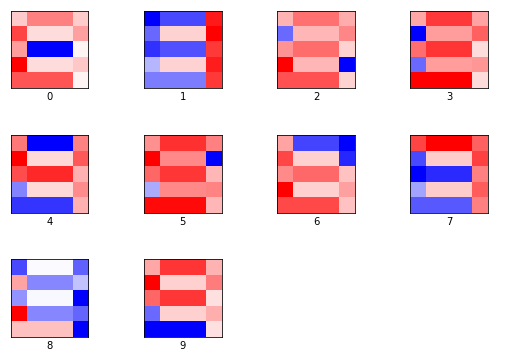

In [18]:
Explain(W_final, b_final, shape_size, img_size)

In [19]:
lcd = Lcd(shape_size)
for digit in range(kind_count):
  v = np.matmul(lcd.display(digit)._display.reshape(1, shape_size * shape_size), W_final) + b_final
  print np.argmax(v), ":", v
print
print "b :", b_final

0 : [[ 0.882 -0.657  0.198  0.115 -0.629  0.152 -0.13  -0.121  0.441 -0.25 ]]
1 : [[ 0.016  0.569 -0.291 -0.07   0.229 -0.318 -0.359  0.325 -0.152  0.05 ]]
2 : [[ 0.174 -1.009  0.822  0.461 -0.499  0.219 -0.038 -0.491  0.501 -0.14 ]]
3 : [[ 0.038 -0.845  0.409  0.593 -0.367  0.352 -0.158 -0.349  0.351 -0.023]]
4 : [[-0.417 -0.197 -0.262 -0.073  0.775 -0.053  0.062 -0.334  0.035  0.465]]
5 : [[ 0.1   -1.067  0.192  0.377 -0.318  0.679  0.144 -0.555  0.407  0.041]]
6 : [[ 0.049 -0.859  0.162  0.098  0.033  0.373  1.055 -1.032  0.433 -0.313]]
7 : [[ 0.218  0.032 -0.12   0.078 -0.206 -0.151 -0.852  0.739 -0.048  0.31 ]]
8 : [[ 0.29  -1.016  0.377  0.279 -0.336  0.31   0.102 -0.557  0.567 -0.016]]
9 : [[-0.227 -0.57  -0.093  0.08   0.286  0.118 -0.465  0.006  0.161  0.703]]

b : [-0.017  0.084 -0.023 -0.033  0.022 -0.029  0.01   0.042 -0.049 -0.008]


In [20]:
sess.close()